#### Вспомогательные либы

In [1]:
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from collections import Counter
import glob
import pickle
import keras
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### ЛР 1. Разработка полностью связанных нейронных сетей

### Постановка задачи

Мы выбрали задачу предсказывания персонажей из мультсериала **Симпсоны**. Набор данных содержит **18 классов / персонажей** (данные по Kaggle содержат 20 классов, но в настоящее время мы использовали только 18 персонажений для обучения). Изображения имеют различный размер и в основном извлечены из эпизодов (сезон 4-24).

In [2]:
map_characters = {
    0: 'abraham_grampa_simpson',
    1: 'apu_nahasapeemapetilon', 
    2: 'bart_simpson', 
    3: 'charles_montgomery_burns', 
    4: 'chief_wiggum', 
    5: 'comic_book_guy', 
    6: 'edna_krabappel', 
    7: 'homer_simpson', 
    8: 'kent_brockman', 
    9: 'krusty_the_clown', 
    10: 'lisa_simpson', 
    11: 'marge_simpson', 
    12: 'milhouse_van_houten', 
    13: 'moe_szyslak', 
    14: 'ned_flanders', 
    15: 'nelson_muntz', 
    16: 'principal_skinner', 
    17: 'sideshow_bob'
}

Картинки имеют формат BGR и разный размер. Поэтому приведет все картинки к фиксированному размеру и к формату RGB. Сразу картинки не будем загружать в память, во избежания переполнения памяти в оперативке. Загружать будем во время батча для тренировки или предсказания

In [3]:
def show_image_from_path(ax, x, y):
    y = map_characters[y]
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    ax.imshow(img)
    ax.text(2, 58, '{}'.format(y), fontsize=12, bbox={'facecolor': 'white', 'pad': 2})

def show_image(ax, image, label):
    ax.imshow(image)
    ax.text(2, 58, '{}'.format(map_characters[label]), fontsize=12, bbox={'facecolor': 'white', 'pad': 2}) 
    
def show_image_with_dict(ax, image, l):
    ax.imshow(image)
    labels = ['{}: {:.2f}'.format(label, value) for label, value in l]
    text = '\n'.join(labels)
    ax.text(2, 58, text, fontsize=9, bbox={'facecolor': 'white', 'pad': 2})
    
def print_example(X,Y):
    f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        show_image_from_path(ax, X[i], Y[i])

In [4]:
def collect_train_paths(images_dir = 'simpsons_dataset/'):
    np.random.seed(42)
    x_path_train = []
    y_train = []
    for key, value in map_characters.items():
        person_images_path = os.listdir(os.path.join(images_dir, value))
        person_images_path.sort()
        x_path_train.extend(list(map(lambda x: os.path.join(images_dir, value, x), person_images_path)))
        y_train.extend([key]*len(person_images_path))

    x_path_train = np.array(x_path_train)
    y_train = np.array(y_train)

    indices = np.arange(x_path_train.shape[0])
    np.random.shuffle(indices)
    x_path_train = x_path_train.take(indices, axis=0)
    y_train = y_train.take(indices, axis=0)
        
    return x_path_train, y_train

In [5]:
def collect_test_paths(images_dir = 'kaggle_simpson_testset/kaggle_simpson_testset'):
    np.random.seed(42)
    x_test_path = []
    y_test = []
    for image_name in os.listdir(images_dir):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label, character in map_characters.items() if character == character_name][0]
        x_test_path.append(os.path.join(images_dir, image_name))
        y_test.append(label)
    
    x_test_path = np.array(x_test_path)
    y_test = np.array(y_test)
    indices = np.arange(x_test_path.shape[0])
    np.random.shuffle(indices)
    x_test_path = x_test_path.take(indices, axis=0)
    y_test = y_test.take(indices, axis=0)
    
    return np.array(x_test_path), np.array(y_test)

Получаем пошафленную тренировочную выборку в виде путей. (Сразу загрузгу не делаем картинок)

In [18]:
x_train_paths, y_train = collect_train_paths('/numerics/egorsmir/simpsons_dataset')

### Тренировочные и тестовые наборы данных.

Тренировочная выборка включает в себя около **1000 изображений на каждого персонажа**. Персонаж не обязательно центрируется на каждом изображении и иногда может быть с другими персонажами (но это должно быть самой важной частью на картинке).

Отобразим несколько картинок тренировочной выборки

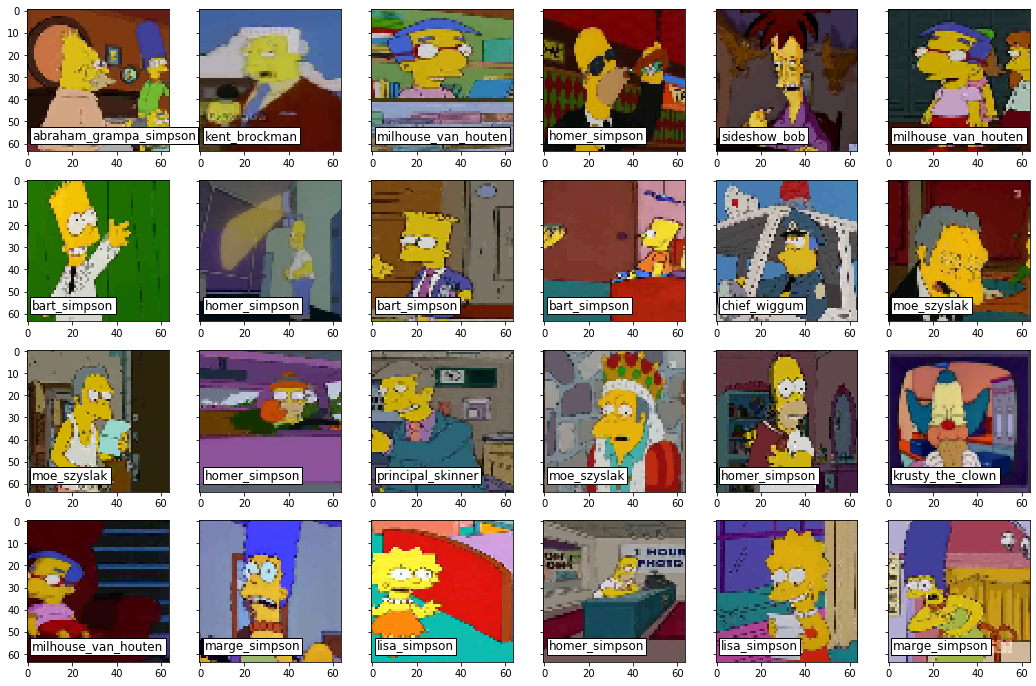

In [19]:
f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
for i, ax in enumerate(axes.flat):
    show_image_from_path(ax, x_train_paths[i], y_train[i]) 

Функции для выдерания батч путей картинок и неспосредственно загрузка батч картинок

In [20]:
def load_from_paths(x_path_batch, img_size=64):
    batches = np.empty((len(x_path_batch), img_size, img_size, 3))

    for i, x_path_i in enumerate(x_path_batch):
        img = cv2.imread(x_path_i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.
        assert img.min() >= 0.0 and img.max() <= 1.0
        batches[i] = img
    return batches

def load_from_paths_batch(x_path, y, batch_size, img_size=64):
    SEED = 42
    np.random.seed(SEED)
    
    n_batch = len(x_path) // batch_size
    while (True):
        indices = np.arange(x_path.shape[0])
        np.random.shuffle(indices)
        x_path_take = x_path.take(indices, axis=0)
        y_take = y.take(indices, axis=0)

        for i in range(0, len(x_path), batch_size):
            x_path_batch = x_path_take[i : i + batch_size]
            y_batch = y_take[i : i + batch_size]
            batches = load_from_paths(x_path_batch, img_size)
            yield (batches, y_batch)

Проверим, что они корректно работают:

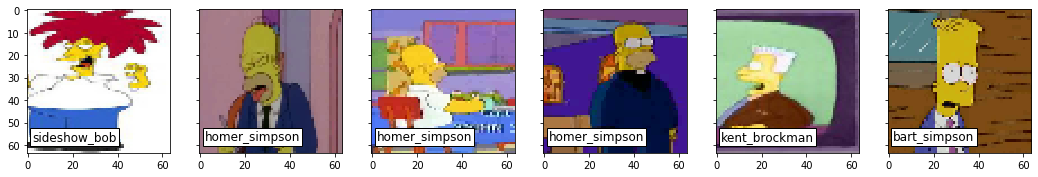

In [21]:
n_image = 6
gen = load_from_paths_batch(x_train_paths, y_train, n_image)
(im, index) = gen.__next__()
f, axes = plt.subplots(1, n_image, sharey=True, figsize=(3*n_image, 3))
for i, ax in enumerate(axes):
    show_image(ax, im[i], index[i])

Валидироваться будем на валидационном датасете, который выделим из тренировочного.

In [22]:
def split_data_set(X, Y):
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.01, random_state=777)
    return x_train, x_val, y_train, y_val

In [23]:
x_train_paths, x_val_paths, y_train, y_val = split_data_set(x_train_paths, y_train)
"train size {} validation size {}".format(x_train_paths.shape, x_val_paths.shape)

'train size (18802,) validation size (190,)'

Тестовая выборка состоит из 50 картнинок на каждого персонажа. Но использовать тестовые данные будем **только на финальной модели** в каждой лабораторной.

Методы для тренировки и тестирования наших моделей:

In [24]:
def train_model(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    generator = load_from_paths_batch(X_train, Y_train, batch_size, img_size)
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model
    
def test_model(model, x_test, img_size=64):
    x_test = load_from_paths(x_test)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, 1)
    return y_pred

### Полносвязанные архитектуры

Создадим простую классическую двухслойную полносвязнную сеть:

$$n \times 64 \times 64 \times 3 \rightarrow n \times 128 \rightarrow RELU \rightarrow n \times 18 \rightarrow SOFTMAX$$

В качестве оптимизатора будем брать адаптивный градиент.

В качестве метрики для многоклассовой задачи возьмем **accuracy**

In [25]:
def build_dense_baseline_model():
    import keras.layers as L

    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=(64,64,3)))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(len(map_characters)))
    model.add(keras.layers.Softmax())

    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    return model

In [99]:
def load_from_paths_batch_auto(x_path, y, batch_size, img_size=64):
    SEED = 42
    np.random.seed(SEED)
    
    n_batch = len(x_path) // batch_size
    n_batch = 0
    while (n_batch>=0):
        n_batch -=1
        indices = np.arange(x_path.shape[0])
        np.random.shuffle(indices)
        x_path_take = x_path.take(indices, axis=0)
        y_take = y.take(indices, axis=0)

        count = 0
        for i in range(0, len(x_path), batch_size):
            x_path_batch = x_path_take[i : i + batch_size]
            batches = load_from_paths(x_path_batch, img_size)
            y_batch = batches
            print("----", count)
            count += 1
            yield (batches, y_batch)

batches = []
def collect_batches():
    gen = load_from_paths_batch_auto(x_train_paths, y_train, 512)
    count = 0
    for i in gen:
        print(count)
        count += 1
        batches.append(i)
collect_batches()
        
        
def supa_gen():
    while (True):
        for i in batches:
            yield i

def load_from_paths_batch_original(x_path, y, batch_size, img_size=64):
    SEED = 42
    np.random.seed(SEED)
    
    n_batch = len(x_path) // batch_size
    n_batch = 0
    while (n_batch>=0):
        n_batch -=1
        indices = np.arange(x_path.shape[0])
        np.random.shuffle(indices)
        x_path_take = x_path.take(indices, axis=0)
        y_take = y.take(indices, axis=0)

        count = 0
        for i in range(0, len(x_path), batch_size):
            x_path_batch = x_path_take[i : i + batch_size]
            batches = load_from_paths(x_path_batch, img_size)
            y_batch = y_take[i : i + batch_size]
            count += 1
            yield (batches, y_batch)

batches_original = []
def collect_batches_original():
    gen = load_from_paths_batch_original(x_train_paths, y_train, 512)
    for i in gen:
        batches_original.append(i)
collect_batches_original()



---- 0
0
---- 1
1
---- 2
2
---- 3
3
---- 4
4
---- 5
5
---- 6
6
---- 7
7
---- 8
8
---- 9
9
---- 10
10
---- 11
11
---- 12
12
---- 13
13
---- 14
14
---- 15
15
---- 16
16
---- 17
17
---- 18
18
---- 19
19
---- 20
20
---- 21
21
---- 22
22
---- 23
23
---- 24
24
---- 25
25
---- 26
26
---- 27
27
---- 28
28
---- 29
29
---- 30
30
---- 31
31
---- 32
32
---- 33
33
---- 34
34
---- 35
35
---- 36
36


In [137]:
def train_model_auto(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    # generator = load_from_paths_batch_auto(X_train, Y_train, batch_size, img_size)
    generator = supa_gen()
    
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, X_val])
    return model


def build_dense_auto1():
    import keras.layers as L
    from keras.layers import Input

    model = keras.models.Sequential()

#     input_img = Input(shape=(28, 28, 1))
    
    model.add(keras.layers.Flatten(input_shape=(64,64,3)))
    model.add(keras.layers.Dense(1024, activation='relu', name='dense_1'))
#     model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(64*64*3))
    model.add(keras.layers.Reshape((64,64,3)))
    
    model.compile(optimizer='adam', loss='mse')
    return model

In [138]:
model_auto = build_dense_auto1()
train_model_auto(model_auto, x_train_paths, y_train, x_val_paths, y_val, epoch=10, batch_size=512, img_size=64)

Epoch 1/10
36/36 [==============================] - 7s 206ms/step - loss: 0.0888 - val_loss: 0.0517
Epoch 2/10
36/36 [==============================] - 7s 197ms/step - loss: 0.0504 - val_loss: 0.0510
Epoch 3/10
36/36 [==============================] - 7s 196ms/step - loss: 0.0478 - val_loss: 0.0462
Epoch 4/10
36/36 [==============================] - 7s 200ms/step - loss: 0.0444 - val_loss: 0.0423
Epoch 5/10
36/36 [==============================] - 7s 199ms/step - loss: 0.0412 - val_loss: 0.0401
Epoch 6/10
36/36 [==============================] - 7s 197ms/step - loss: 0.0386 - val_loss: 0.0374
Epoch 7/10
36/36 [==============================] - 7s 197ms/step - loss: 0.0366 - val_loss: 0.0354
Epoch 8/10
36/36 [==============================] - 7s 199ms/step - loss: 0.0348 - val_loss: 0.0338
Epoch 9/10
36/36 [==============================] - 7s 200ms/step - loss: 0.0334 - val_loss: 0.0326
Epoch 10/10
36/36 [==============================] - 7s 201ms/step - loss: 0.0323 - val_loss: 0.0316

TypeError: Invalid shape (18,) for image data

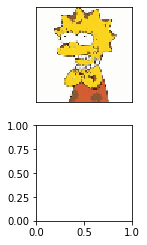

In [141]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

n_image = 6
gen = load_from_paths_batch(x_train_paths, y_train, n_image)
(encoded_imgs, index) = gen.__next__()
decoded_imgs = model.predict(encoded_imgs)
# print(decoded_imgs[0])
# print(encoded_imgs[0])

plot_digits(encoded_imgs, decoded_imgs)

In [186]:
def supa_gen_original():
    while (True):
        for i in batches_original:
            yield i

def train_model_original(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    # generator = load_from_paths_batch_auto(X_train, Y_train, batch_size, img_size)
    generator = supa_gen_original()
    
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model


def build_dense_model_to_train():
    import keras.layers as L

    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=(64,64,3)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(len(map_characters)))
    model.add(keras.layers.Softmax())

    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    return model

def build_dense_model_to_train_auto():
    
    import keras.layers as L
    from keras import backend as K
    
    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=(64,64,3)))
    model.add(model_auto.layers[1])
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(len(map_characters)))
    model.add(keras.layers.Softmax())

    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    #     model.layers[1].weights = K.eval(model_auto.layers[1].get_weights())
    return model


In [ ]:
model_auto = build_dense_model_to_train_auto()
train_model_auto(model_auto, x_val_paths, y_train, x_val_paths, y_val, epoch=10, batch_size=512, img_size=64)
model = build_dense_model_to_train()
train_model(model, x_train_paths, y_train, x_val_paths, y_val, epoch=10, batch_size=512, img_size=64)

In [198]:
def build_own_conv_model_auto(img_size=64, l2_reg=0.0, n_layers=1, n_conv=16, batch_norm=False):
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation, Flatten
    from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
    from keras.layers.normalization import BatchNormalization
    from keras.regularizers import l2
    
    n_classes = len(map_characters)

    model = Sequential()
    model.add(Conv2D(n_conv, (5, 5), input_shape=(img_size, img_size, 3), padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(n_layers - 1):
        model.add(Conv2D(n_conv, (3, 3), padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if batch_norm: model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dense(64*64*3))
#     model.add(Dense(n_classes))
#     model.add(Activation('softmax'))
    
    model.add(keras.layers.Reshape((64,64,3)))
    
    model.compile(optimizer='adam', loss='mse')
    
#     model.compile(
#         optimizer="adam", 
#         loss=keras.losses.sparse_categorical_crossentropy, 
#         metrics=[keras.metrics.sparse_categorical_accuracy]
#     )
    
    return model

In [249]:
model_auto = build_own_conv_model_auto(n_layers=3, n_conv=32, l2_reg=0.0,  batch_norm=False)

In [250]:
train_model_auto(model_auto, x_train_paths, y_train, x_val_paths, y_val, 
                            epoch=5, batch_size=512, verbose=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


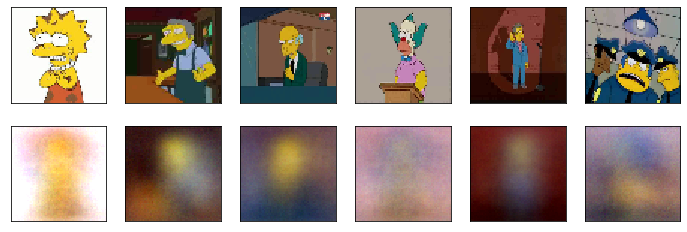

In [251]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

n_image = 6
gen = load_from_paths_batch(x_train_paths, y_train, n_image)
(encoded_imgs, index) = gen.__next__()
decoded_imgs = model_auto.predict(encoded_imgs)
# print(decoded_imgs[0])
# print(encoded_imgs[0])

plot_digits(encoded_imgs, decoded_imgs)

In [207]:
def build_own_conv_model(img_size=64, l2_reg=0.0, n_layers=1, n_conv=16, batch_norm=False):
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation, Flatten
    from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
    from keras.layers.normalization import BatchNormalization
    from keras.regularizers import l2
    
    n_classes = len(map_characters)

    model = Sequential()
    model.add(Conv2D(n_conv, (5, 5), input_shape=(img_size, img_size, 3), padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(n_layers - 1):
        model.add(Conv2D(n_conv, (3, 3), padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if batch_norm: model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    
    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    
    return model

In [208]:
model_wo_auto = build_own_conv_model(n_layers=3, n_conv=32, l2_reg=0.0,  batch_norm=False)

In [211]:
def supa_gen_original():
    while (True):
        for i in batches_original:
            yield i

def train_model_simple(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    # generator = load_from_paths_batch_auto(X_train, Y_train, batch_size, img_size)
    generator = supa_gen_original()
    
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model

In [216]:
train_model_simple(model_wo_auto, x_train_paths, y_train, x_val_paths, y_val, 
                            epoch=5, batch_size=512, verbose=0)

In [217]:
pred_train  = test_model(model_wo_auto, x_val_paths, img_size=64)
print("Accuracy: \t" , (pred_train == y_val).mean())

Training: 	 0.7315789473684211


In [219]:
model_auto.layers[0].name

'conv2d_1'

In [252]:
def build_own_conv_model_use_auto(img_size=64, l2_reg=0.0, n_layers=1, n_conv=16, batch_norm=False):
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation, Flatten
    from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
    from keras.layers.normalization import BatchNormalization
    from keras.regularizers import l2
    
    n_classes = len(map_characters)

    model = Sequential()
    
    count = 0
    model.add(model_auto.layers[count])
    count +=1
    model.add(model_auto.layers[count])
    count +=1
    model.add(model_auto.layers[count])
    count +=1
    for i in range(n_layers - 1):
        model.add(model_auto.layers[count])
        count +=1
        model.add(model_auto.layers[count])
        count +=1
        model.add(model_auto.layers[count])
        count +=1
        if batch_norm:
            model.add(model_auto.layers[count])
            count +=1

    model.add(model_auto.layers[count])
    count +=1
    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dense(n_classes))
    model.add(Activation('softmax'))

    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    
    print(1)
    return model

In [253]:
model_w_auto = build_own_conv_model_use_auto(n_layers=3, n_conv=32, l2_reg=0.0,  batch_norm=False)

1


In [256]:
def train_model_simple_auto(model_w_auto, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    # generator = load_from_paths_batch_auto(X_train, Y_train, batch_size, img_size)
    generator = supa_gen_original()
    
    model_w_auto.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model

train_model_simple_auto(model_w_auto, x_train_paths, y_train, x_val_paths, y_val, 
                            epoch=5, batch_size=512, verbose=0)

In [257]:
pred_train  = test_model(model_w_auto, x_val_paths, img_size=64)
print("Accuracy: \t" , (pred_train == y_val).mean())

Accuracy: 	 0.7631578947368421
